In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm
import time
import torch
import numpy as np
import ase.io as aio
from ase import Atoms
import skimage
from toolz.curried import pipe, curry

In [3]:
import plot
import atommks.porosity as pore
import atommks.helpers as utils
import atommks.grid_generator as gen
from atommks.correlations import compute_statistics

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [5]:
from ase import Atoms 
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

runs = np.loadtxt("runs.txt").astype(int)

In [6]:
def grid_maker(fname, len_pixel=1, r_atom=5.0, r_stat=50, ):
    atoms = pipe(fname, 
                 lambda f: utils.load_file(f), 
                 lambda a: get_atoms(a))
    
    idx = np.where(atoms.get_tags() != 1)[0]    
    if len(idx) == 0:
        np.random.seed(81396)
        idx = np.random.randint(low=0, high=len(atoms), size=2000)
    
    coords_all = atoms.get_positions()
    coords_sub = coords_all[idx]
    
    atoms_1 = Atoms(positions=coords_sub,  cell=atoms.get_cell(), pbc=atoms.get_pbc())
    

    radii = {}
    for idx in sorted(np.unique(atoms_1.get_chemical_symbols())):
        radii[idx] = r_atom
        
    S, S_list, box_dim = gen.grid_maker(atoms_1, len_pixel=len_pixel, atomic_radii=radii, full=False, fft=True)
    
    S_cas = S_list[0]

    S_gg = compute_statistics(boundary="nonperiodic", corrtype="auto", 
                              cutoff=50, device=torch.device("cpu"), args0=S_cas)
    
    
    erase = pore.erasure(min_size = 15)
    label = lambda s: pore.return_labelled(s)[0]
    
    S_cln = pore.gen_cleanPore(S_cas, r_probe=0, r_min=3, len_pixel=len_pixel)

    S_lbl, n_count, m = pore.return_labelled(S_cln)
    
    return S_cas, S_gg, S_lbl

In [48]:
# %%time
# for run in tqdm.tqdm_notebook(runs):
#     fname = "data/structs/dump.arc.{}_atom.pkl".format(run)
#     S_cas, S_gg, S_lbl = grid_maker(fname)

#     d = {}
#     d["cas"] = S_cas
#     d["gg"] = S_gg
#     d["lbl"] = S_lbl

#     f_out = "{}/dump.arc.{}_grid.pkl".format("data/grids", run)
#     utils.save_file(fname=f_out, obj=d)

/storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.



CPU times: user 53min 15s, sys: 8min 48s, total: 1h 2min 4s
Wall time: 9min 44s


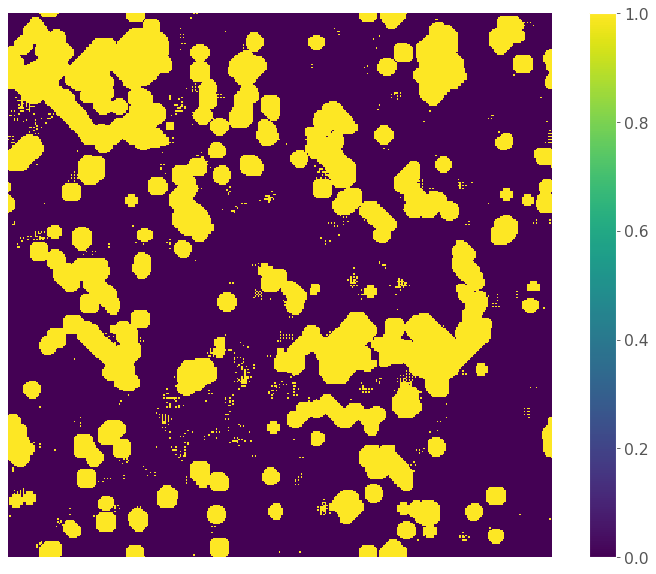

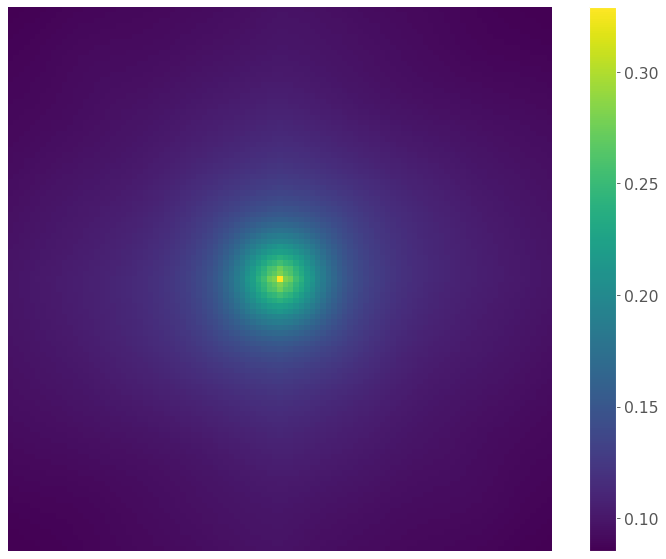

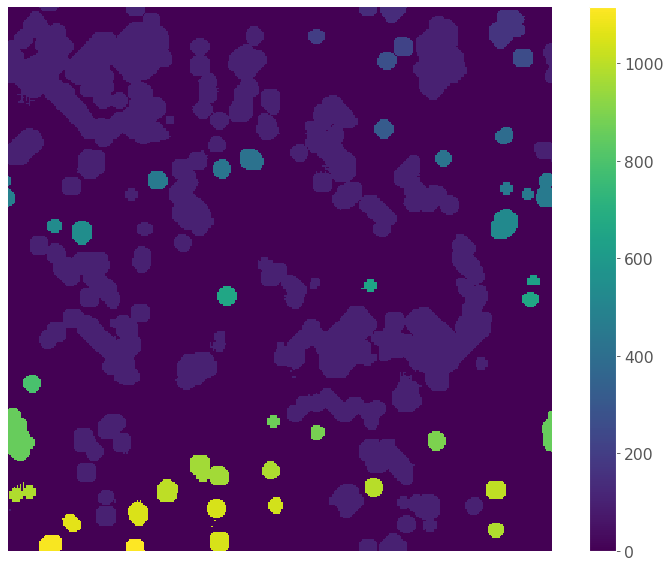

In [8]:
d = utils.load_file("data/grids/dump.arc.5000_grid.pkl")

idx = d["cas"].shape[0]//2
plot.draw_2d(d["cas"][:,:,idx])
plot.draw_2d(d["gg"][:,:,50])
plot.draw_2d(((d["lbl"] + 100) * (d["lbl"] > 0) * 1)[:,:,idx])

In [13]:
d["lbl"].shape

(364, 364, 365)

In [15]:
lbls = np.unique(d["lbl"])[1:]

In [16]:
lbls

array([   1,    2,    3, ..., 1026, 1027, 1028], dtype=int32)

# Load reference structure

In [6]:
%%time
ix=10
atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
             lambda f: utils.load_file(f), 
             lambda a: get_atoms(a))

idx = np.where(atoms.get_tags() != 1)[0]
print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))

if len(idx) == 0:
    np.random.seed(81396)
    idx = np.random.randint(low=0, high=len(atoms), size=2000)

coords_all = atoms.get_positions()
coords_sub = coords_all[idx]

obj = utils.load_file("data/stat_indxs_cutoff_150/dump.arc.{}_stat.pkl".format(runs[ix]))
indexes = obj["indexes"]

rmsd = utils.load_file("data/rmsds/dump.arc.{}_rmsd.pkl".format(runs[ix]))
rmsd[np.where(rmsd == np.inf)] = 1

total atoms: 4000000, disturbed atoms: 244316
CPU times: user 9.93 s, sys: 3.33 s, total: 13.3 s
Wall time: 8.93 s


In [7]:
atoms_0 = Atoms(positions=coords_all, cell=atoms.get_cell(), pbc=atoms.get_pbc())
atoms_1 = Atoms(positions=coords_sub,  cell=atoms.get_cell(), pbc=atoms.get_pbc())

# Visualization of the Cascade 

In [47]:
atom_ids = sorted(np.unique(atoms_1.get_chemical_symbols()))

r_atom = 5.0

radii = {}
for idx in atom_ids:
    radii[idx] = r_atom

In [48]:
%%time
len_pixel = 1
S, S_list, box_dim = gen.grid_maker(atoms_1, len_pixel=len_pixel, atomic_radii=radii, full=False, fft=True)
print(S.shape)

(364, 364, 365)
CPU times: user 15.3 s, sys: 3.16 s, total: 18.5 s
Wall time: 1.58 s


15906452


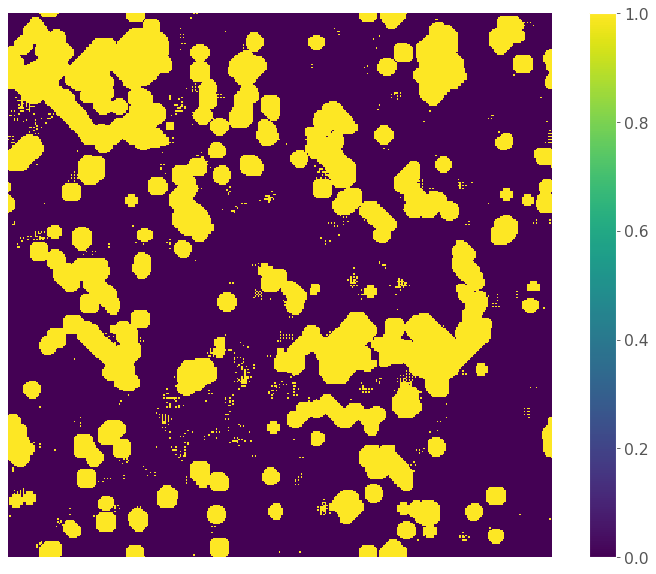

In [50]:
S_cas = S_list[0]
print(np.count_nonzero(S_cas))

idx = S.shape[0]//2
plot.draw_2d(S_cas[:,:,idx])

In [38]:
# To generate vtk file of the accessible void region for visualization
# utils.write2vtk(S_cas, "run_{}_cascade.vtk".format(runs[10]))

In [51]:
stat_cutoff = 50
S_gg = compute_statistics(boundary="nonperiodic", corrtype="auto", cutoff=stat_cutoff, device=torch.device("cpu"), args0=S_cas)

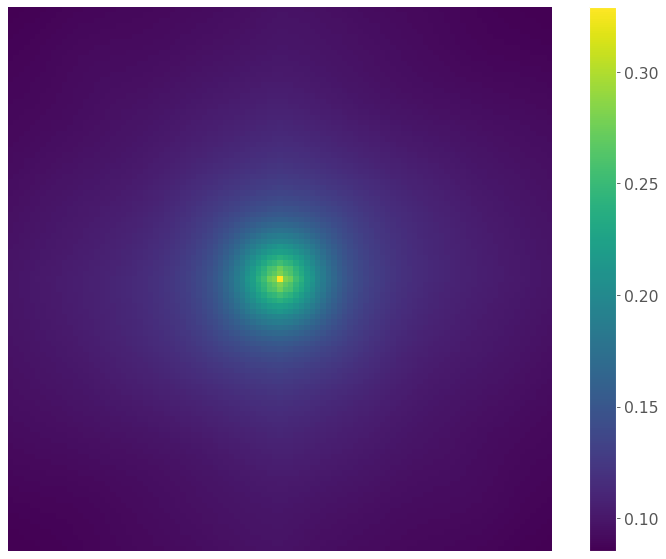

In [52]:
plot.draw_2d(S_gg[:,:,stat_cutoff])

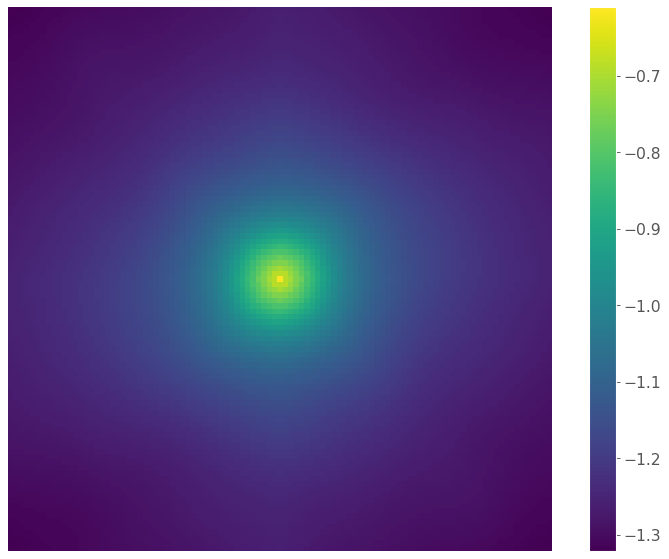

In [35]:
plot.draw_2d(np.log10(S_gg[:,:,stat_cutoff]))

# Feature Extraction from the cascade

In [124]:
av = np.count_nonzero(S_cas) * (1 / len_pixel)**3
print("Probe Accessible Volume: %1.3f" % av)

Probe Accessible Volume: 15906452.000


In [109]:
erase = pore.erasure(min_size = 3)
label = lambda s: pore.return_labelled(s)[0]

In [138]:
erase = pore.erasure(min_size = 3)
label = lambda s: pore.return_labelled(s)[0]

S_clean = pore.gen_cleanPore(S_cas, r_probe=0, r_min=3, len_pixel=len_pixel)

S_l0, n_count, m = pore.return_labelled(S_cas)
print("No. of unconnected regions: {}".format(n_count))

S_l, n_count, m = pore.return_labelled(S_clean)
print("No. of unconnected regions: {}".format(n_count))

No. of unconnected regions: 777329
No. of unconnected regions: 1028


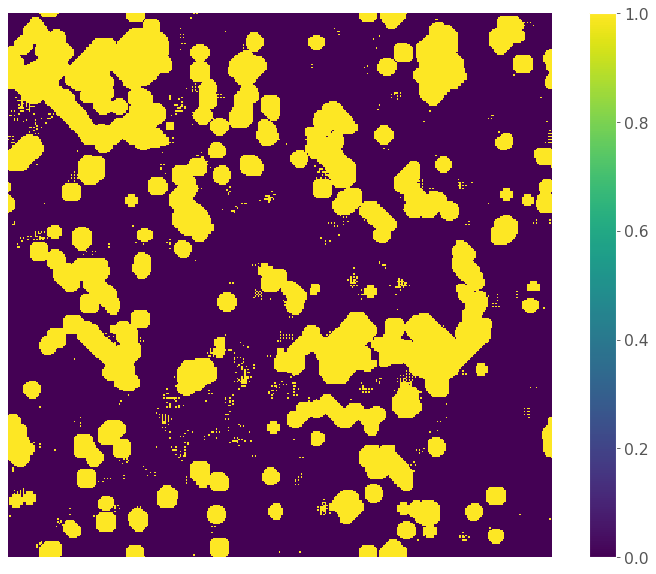

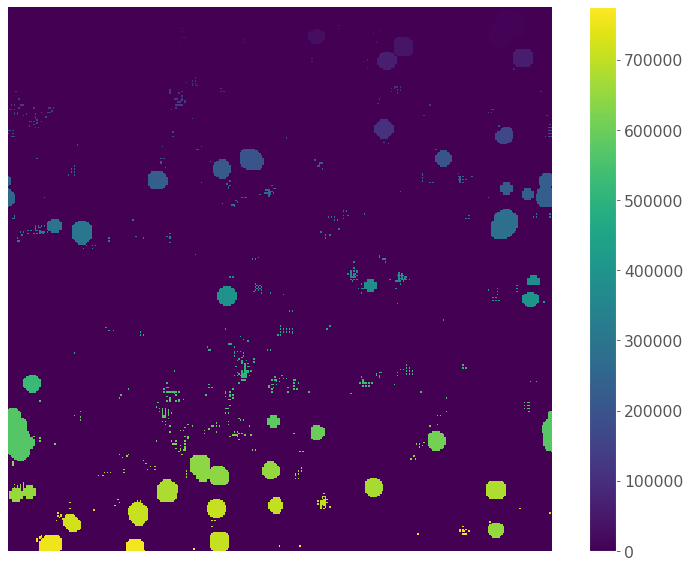

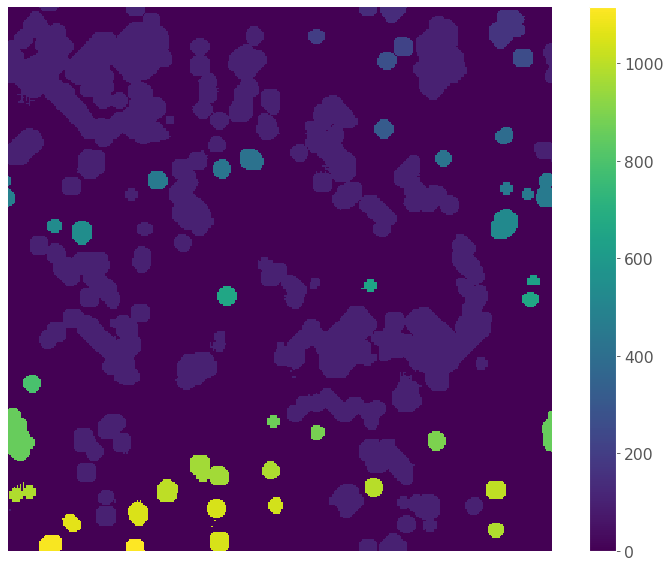

In [153]:
idx = S_cas.shape[0]//2
plot.draw_2d(S_cas[:,:,idx])
plot.draw_2d(((S_l0 + 100) * (S_l0 > 0) * 1)[:,:,idx])
plot.draw_2d(((S_l + 100) * (S_l > 0) * 1)[:,:,idx])

In [156]:
props = skimage.measure.regionprops(S_l)